In [1]:
import tensorflow as tf
import tensorflow .contrib.slim as slim
import numpy as np
import random
from game_env import gameEnv
import os
import matplotlib.pyplot as plt
import scipy.misc

c:\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gameEnv(84,3)
env.drawGridState()
env.actions

12

In [3]:
class Qnetwork():
    def __init__(self,h_size):
        #Receives a (P,P,3) representation of the game, pixels x pixels by rgb,
        #specified when creating game environment
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])

        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [5]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [6]:
def processState(states):
    return np.reshape(states,[21168])

In [7]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 50000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [8]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Resetting env and getting first observation
        env.reset()
        s = env.reset()
        s = processState(s)

        d = env.game_over
        rAll = 0
        j = 0
        #The Q-Network
        #If agent takes longer than max episodes, end trial
        while j < max_epLength:
            j += 1
            #Choose action greedily(with e chance of random action) from Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,env.actions)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) 
            #Save the experience to our episode buffer.
            

            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")
            
            
            
            
            
            
            

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Saved Model
259 -5.9 1
521 -5.640000000000001 1
711 -4.6 1
982 -5.94 1
1177 -4.220000000000001 1
1438 -5.74 1
1743 -6.460000000000001 1
1874 -3.22 1
2171 -6.540000000000002 1
2460 -6.300000000000001 1
2704 -5.5200000000000005 1
2971 -5.98 1
3286 -6.779999999999999 1
3487 -4.74 1
3689 -4.6400000000000015 1
3927 -5.28 1
4133 -4.76 1
4412 -6.1000000000000005 1
4594 -4.16 1
4895 -6.540000000000001 1
5110 -4.9399999999999995 1
5347 -5.38 1
5622 -6.100000000000002 1
5870 -5.4 1
6067 -4.659999999999999 1
6218 -3.62 1
6468 -5.4399999999999995 1
6611 -3.46 1
6846 -5.340000000000001 1
7048 -4.440000000000002 1
7274 -5.240000000000001 1
7460 -4.120000000000001 1
7649 -4.580000000000001 1
7896 -5.260000000000001 1
8111 -5.020000000000001 1
8406 -6.420000000000002 1
8585 -4.380000000000001 1
8834 -5.780000000000002 1
9022 -4.360000000000001 1
9232 -4.92 1
9520 -6.4 1
9782 -5.88 1
10029 -5.74 0.997389999999999
10291 -5.96000000

38125 -0.27999999999999997 0.09999999999985551
38200 -0.29999999999999993 0.09999999999985551
38272 -0.24000000000000005 0.09999999999985551
38349 -0.33999999999999997 0.09999999999985551
38424 -0.29999999999999993 0.09999999999985551
38503 -0.37999999999999995 0.09999999999985551
38568 -0.09999999999999998 0.09999999999985551
38651 -0.45999999999999996 0.09999999999985551
38725 -0.2799999999999999 0.09999999999985551
38793 -0.15999999999999998 0.09999999999985551
38856 -0.059999999999999984 0.09999999999985551
38932 -0.32 0.09999999999985551
39000 -0.15999999999999998 0.09999999999985551
39059 0.019999999999999997 0.09999999999985551
39135 -0.31999999999999995 0.09999999999985551
39202 -0.13999999999999996 0.09999999999985551
39281 -0.38 0.09999999999985551
39344 -0.059999999999999984 0.09999999999985551
39435 -0.6199999999999999 0.09999999999985551
39501 -0.12 0.09999999999985551
39575 -0.2799999999999999 0.09999999999985551
39679 -0.8800000000000001 0.09999999999985551
39760 -0.4200

51210 -0.58 0.09999999999985551
51278 -0.15999999999999998 0.09999999999985551
51349 -0.21999999999999992 0.09999999999985551
51425 -0.32 0.09999999999985551
51506 -0.42000000000000004 0.09999999999985551
51575 -0.17999999999999997 0.09999999999985551
51641 -0.11999999999999997 0.09999999999985551
51703 -0.039999999999999994 0.09999999999985551
51801 -0.7600000000000003 0.09999999999985551
51878 -0.3399999999999999 0.09999999999985551
Saved Model
51954 -0.3200000000000001 0.09999999999985551
52025 -0.21999999999999992 0.09999999999985551
52096 -0.42000000000000004 0.09999999999985551
52168 -0.23999999999999994 0.09999999999985551
52233 -0.10000000000000002 0.09999999999985551
52303 -0.4 0.09999999999985551
52357 0.11999999999999997 0.09999999999985551
52420 -0.059999999999999984 0.09999999999985551
52486 -0.11999999999999997 0.09999999999985551
52569 -0.45999999999999996 0.09999999999985551
52634 -0.09999999999999998 0.09999999999985551
52701 -0.13999999999999996 0.09999999999985551
52

63771 -0.13999999999999996 0.09999999999985551
63836 -0.09999999999999998 0.09999999999985551
63903 -0.13999999999999996 0.09999999999985551
63980 -0.33999999999999997 0.09999999999985551
64052 -0.24000000000000005 0.09999999999985551
64127 -0.29999999999999993 0.09999999999985551
64198 -0.22000000000000003 0.09999999999985551
64264 -0.11999999999999997 0.09999999999985551
64327 -0.059999999999999984 0.09999999999985551
64390 -0.059999999999999984 0.09999999999985551
64455 -0.09999999999999998 0.09999999999985551
64522 -0.13999999999999996 0.09999999999985551
64598 -0.52 0.09999999999985551
64670 -0.24 0.09999999999985551
64741 -0.21999999999999992 0.09999999999985551
64803 -0.039999999999999994 0.09999999999985551
64875 -0.43999999999999995 0.09999999999985551
64935 -0.2 0.09999999999985551
64997 -0.039999999999999994 0.09999999999985551
65062 -0.29999999999999993 0.09999999999985551
65133 -0.22000000000000003 0.09999999999985551
65192 0.019999999999999997 0.09999999999985551
65254 -0

76832 -0.31999999999999995 0.09999999999985551
76900 -0.15999999999999998 0.09999999999985551
76959 0.019999999999999997 0.09999999999985551
77030 -0.21999999999999992 0.09999999999985551
77088 -0.16 0.09999999999985551
77156 -0.15999999999999998 0.09999999999985551
77224 -0.35999999999999993 0.09999999999985551
77290 -0.11999999999999997 0.09999999999985551
77352 -0.44000000000000006 0.09999999999985551
77414 -0.23999999999999994 0.09999999999985551
77495 -0.41999999999999993 0.09999999999985551
77572 -0.5399999999999999 0.09999999999985551
77641 -0.17999999999999997 0.09999999999985551
77739 -0.7600000000000001 0.09999999999985551
77810 -0.21999999999999992 0.09999999999985551
77888 -0.36 0.09999999999985551
77951 -0.25999999999999995 0.09999999999985551
78031 -0.4 0.09999999999985551
78092 -0.22000000000000003 0.09999999999985551
78158 -0.31999999999999995 0.09999999999985551
78231 -0.4600000000000001 0.09999999999985551
78308 -0.74 0.09999999999985551
78378 -0.19999999999999993 0.0

89715 -0.09999999999999998 0.09999999999985551
89782 -0.13999999999999996 0.09999999999985551
89837 -0.3 0.09999999999985551
89906 -0.38 0.09999999999985551
89968 -0.039999999999999994 0.09999999999985551
90051 -0.6599999999999999 0.09999999999985551
90123 -0.23999999999999994 0.09999999999985551
90200 -0.5399999999999999 0.09999999999985551
90265 -0.09999999999999998 0.09999999999985551
90326 -0.22000000000000003 0.09999999999985551
90404 -0.76 0.09999999999985551
90463 -0.18 0.09999999999985551
90530 -0.13999999999999996 0.09999999999985551
90594 -0.07999999999999999 0.09999999999985551
90661 -0.13999999999999996 0.09999999999985551
90727 -0.11999999999999997 0.09999999999985551
90796 -0.38 0.09999999999985551
90869 -0.25999999999999995 0.09999999999985551
90934 -0.3 0.09999999999985551
91008 -0.27999999999999997 0.09999999999985551
91079 -0.41999999999999993 0.09999999999985551
91150 -0.21999999999999992 0.09999999999985551
91216 -0.12 0.09999999999985551
91276 0.0 0.099999999999855

102115 -0.22000000000000003 0.09999999999985551
102168 -0.06000000000000001 0.09999999999985551
102248 -0.6000000000000001 0.09999999999985551
102310 -0.039999999999999994 0.09999999999985551
102373 -0.059999999999999984 0.09999999999985551
102440 -0.13999999999999996 0.09999999999985551
102502 -0.23999999999999994 0.09999999999985551
102571 -0.17999999999999997 0.09999999999985551
102630 0.019999999999999997 0.09999999999985551
102691 -0.21999999999999992 0.09999999999985551
102756 -0.09999999999999998 0.09999999999985551
102842 -0.5199999999999999 0.09999999999985551
102917 -0.3000000000000001 0.09999999999985551
102978 -0.019999999999999997 0.09999999999985551
103049 -0.21999999999999992 0.09999999999985551
103117 -0.36 0.09999999999985551
103178 -0.019999999999999997 0.09999999999985551
103253 -0.29999999999999993 0.09999999999985551
103332 -0.3799999999999999 0.09999999999985551
103404 -0.23999999999999994 0.09999999999985551
103466 -0.039999999999999994 0.09999999999985551
103524

114257 -0.11999999999999997 0.09999999999985551
114328 -0.21999999999999992 0.09999999999985551
114391 -0.059999999999999984 0.09999999999985551
114459 -0.15999999999999998 0.09999999999985551
114524 -0.09999999999999998 0.09999999999985551
114605 -0.4199999999999998 0.09999999999985551
114667 -0.039999999999999994 0.09999999999985551
114728 -0.019999999999999997 0.09999999999985551
114811 -0.45999999999999996 0.09999999999985551
114887 -0.31999999999999995 0.09999999999985551
114959 -0.43999999999999995 0.09999999999985551
115034 -0.5 0.09999999999985551
115107 -0.25999999999999995 0.09999999999985551
115170 -0.059999999999999984 0.09999999999985551
115237 -0.13999999999999996 0.09999999999985551
115303 -0.11999999999999997 0.09999999999985551
115386 -0.45999999999999996 0.09999999999985551
115459 -0.25999999999999995 0.09999999999985551
115517 -0.16 0.09999999999985551
115577 0.0 0.09999999999985551
115634 -0.14000000000000007 0.09999999999985551
115705 -0.21999999999999992 0.0999999

126388 -0.15999999999999998 0.09999999999985551
126460 -0.24 0.09999999999985551
126523 -0.059999999999999984 0.09999999999985551
126599 -0.5199999999999999 0.09999999999985551
126668 -0.18 0.09999999999985551
126729 -0.019999999999999997 0.09999999999985551
Saved Model
126800 -0.4200000000000001 0.09999999999985551
126873 -0.25999999999999995 0.09999999999985551
126942 -0.37999999999999995 0.09999999999985551
127012 -0.20000000000000004 0.09999999999985551
127079 -0.13999999999999996 0.09999999999985551
127160 -0.6199999999999999 0.09999999999985551
127222 -0.039999999999999994 0.09999999999985551
127286 -0.07999999999999999 0.09999999999985551
127349 -0.25999999999999995 0.09999999999985551
127415 -0.11999999999999997 0.09999999999985551
127481 -0.11999999999999997 0.09999999999985551
127561 -0.39999999999999997 0.09999999999985551
127623 -0.039999999999999994 0.09999999999985551
127685 -0.039999999999999994 0.09999999999985551
127747 -0.039999999999999994 0.09999999999985551
127813 

138059 -0.19999999999999996 0.09999999999985551
138115 -0.12000000000000002 0.09999999999985551
138180 -0.09999999999999998 0.09999999999985551
138247 -0.13999999999999996 0.09999999999985551
138302 -0.10000000000000002 0.09999999999985551
138366 -0.47999999999999987 0.09999999999985551
138439 -0.25999999999999995 0.09999999999985551
138507 -0.36 0.09999999999985551
138570 -0.25999999999999995 0.09999999999985551
138631 -0.019999999999999997 0.09999999999985551
138702 -0.21999999999999992 0.09999999999985551
138769 -0.13999999999999996 0.09999999999985551
138840 -0.21999999999999992 0.09999999999985551
138907 -0.33999999999999997 0.09999999999985551
138964 -0.13999999999999999 0.09999999999985551
139026 -0.43999999999999995 0.09999999999985551
139115 -0.5800000000000001 0.09999999999985551
139177 -0.23999999999999994 0.09999999999985551
139247 -0.39999999999999997 0.09999999999985551
139340 -0.6600000000000004 0.09999999999985551
139401 -0.21999999999999997 0.09999999999985551
139464 -

149999 -0.07999999999999999 0.09999999999985551
150078 -0.37999999999999995 0.09999999999985551
150133 -0.10000000000000002 0.09999999999985551
150199 -0.11999999999999997 0.09999999999985551
150273 -0.4800000000000001 0.09999999999985551
150342 -0.17999999999999997 0.09999999999985551
150405 -0.059999999999999984 0.09999999999985551
150472 -0.33999999999999997 0.09999999999985551
150543 -0.2200000000000001 0.09999999999985551
150614 -0.41999999999999993 0.09999999999985551
150695 -0.41999999999999993 0.09999999999985551
150758 -0.25999999999999995 0.09999999999985551
150820 -0.039999999999999994 0.09999999999985551
150889 -0.18 0.09999999999985551
150964 -0.29999999999999993 0.09999999999985551
151040 -0.31999999999999995 0.09999999999985551
151112 -0.24 0.09999999999985551
151186 -0.48 0.09999999999985551
151240 -0.08 0.09999999999985551
151300 0.0 0.09999999999985551
151375 -0.3000000000000001 0.09999999999985551
151446 -0.21999999999999992 0.09999999999985551
151514 -0.359999999999

162329 -0.25999999999999995 0.09999999999985551
162398 -0.38 0.09999999999985551
162464 -0.11999999999999997 0.09999999999985551
162523 0.019999999999999997 0.09999999999985551
162596 -0.45999999999999996 0.09999999999985551
162660 -0.07999999999999999 0.09999999999985551
162733 -0.25999999999999995 0.09999999999985551
162792 0.019999999999999997 0.09999999999985551
162852 0.0 0.09999999999985551
162916 -0.08 0.09999999999985551
162974 0.039999999999999994 0.09999999999985551
163039 -0.09999999999999998 0.09999999999985551
163103 -0.07999999999999999 0.09999999999985551
163173 -0.19999999999999993 0.09999999999985551
163241 -0.15999999999999998 0.09999999999985551
163296 0.09999999999999998 0.09999999999985551
163370 -0.2799999999999999 0.09999999999985551
163428 0.039999999999999994 0.09999999999985551
163506 -0.36 0.09999999999985551
163566 -0.19999999999999998 0.09999999999985551
163630 -0.07999999999999999 0.09999999999985551
163699 -0.38000000000000006 0.09999999999985551
163767 -

174346 -0.23999999999999994 0.09999999999985551
174422 -0.31999999999999995 0.09999999999985551
174485 -0.059999999999999984 0.09999999999985551
174565 -0.3999999999999999 0.09999999999985551
174634 -0.38000000000000006 0.09999999999985551
174694 0.0 0.09999999999985551
174754 0.0 0.09999999999985551
174812 -0.15999999999999998 0.09999999999985551
174873 -0.019999999999999997 0.09999999999985551
174945 -0.23999999999999994 0.09999999999985551
175012 -0.33999999999999997 0.09999999999985551
175079 -0.13999999999999996 0.09999999999985551
175140 -0.019999999999999997 0.09999999999985551
175205 -0.3 0.09999999999985551
175263 0.039999999999999994 0.09999999999985551
175335 -0.23999999999999994 0.09999999999985551
175403 -0.15999999999999998 0.09999999999985551
175483 -0.3999999999999999 0.09999999999985551
175554 -0.22000000000000003 0.09999999999985551
175615 -0.019999999999999997 0.09999999999985551
175684 -0.17999999999999997 0.09999999999985551
175744 -0.19999999999999998 0.0999999999

Saved Model
186398 -0.07999999999999999 0.09999999999985551
186472 -0.2799999999999999 0.09999999999985551
186535 -0.059999999999999984 0.09999999999985551
186603 -0.36 0.09999999999985551
186669 -0.11999999999999997 0.09999999999985551
186737 -0.36 0.09999999999985551
186807 -0.3999999999999999 0.09999999999985551
186874 -0.13999999999999996 0.09999999999985551
186938 -0.07999999999999999 0.09999999999985551
187004 -0.12 0.09999999999985551
187068 -0.27999999999999997 0.09999999999985551
187131 -0.25999999999999995 0.09999999999985551
187203 -0.23999999999999994 0.09999999999985551
187266 -0.06000000000000003 0.09999999999985551
187324 0.039999999999999994 0.09999999999985551
187388 -0.07999999999999999 0.09999999999985551
187460 -0.44000000000000006 0.09999999999985551
187530 -0.4 0.09999999999985551
187592 -0.039999999999999994 0.09999999999985551
187652 0.0 0.09999999999985551
187732 -0.4 0.09999999999985551
187796 -0.07999999999999999 0.09999999999985551
187854 0.03999999999999999

198447 -0.41999999999999993 0.09999999999985551
198508 -0.21999999999999992 0.09999999999985551
198574 -0.31999999999999995 0.09999999999985551
198643 -0.38000000000000006 0.09999999999985551
198703 -0.19999999999999998 0.09999999999985551
198762 0.019999999999999997 0.09999999999985551
198825 -0.059999999999999984 0.09999999999985551
198889 -0.07999999999999999 0.09999999999985551
198955 -0.11999999999999997 0.09999999999985551
199019 -0.47999999999999987 0.09999999999985551
199083 -0.47999999999999987 0.09999999999985551
199151 -0.15999999999999998 0.09999999999985551
199219 -0.36 0.09999999999985551
199291 -0.23999999999999994 0.09999999999985551
199355 -0.07999999999999999 0.09999999999985551
199419 -0.07999999999999999 0.09999999999985551
199488 -0.17999999999999997 0.09999999999985551
199560 -0.23999999999999994 0.09999999999985551
199623 -0.059999999999999984 0.09999999999985551
199681 -0.36 0.09999999999985551
Saved Model
199759 -0.36000000000000004 0.09999999999985551
199847 -

210237 -0.25999999999999995 0.09999999999985551
210307 -0.19999999999999996 0.09999999999985551
210374 -0.13999999999999996 0.09999999999985551
210450 -0.5199999999999998 0.09999999999985551
210517 -0.13999999999999996 0.09999999999985551
210580 -0.059999999999999984 0.09999999999985551
210647 -0.13999999999999999 0.09999999999985551
210715 -0.36 0.09999999999985551
210778 -0.25999999999999995 0.09999999999985551
210849 -0.21999999999999992 0.09999999999985551
210910 -0.22000000000000003 0.09999999999985551
210972 -0.039999999999999994 0.09999999999985551
211039 -0.13999999999999996 0.09999999999985551
211094 0.09999999999999998 0.09999999999985551
211168 -0.27999999999999997 0.09999999999985551
211236 -0.16000000000000003 0.09999999999985551
211301 -0.1 0.09999999999985551
211375 -0.2800000000000001 0.09999999999985551
211458 -0.6599999999999999 0.09999999999985551
211526 -0.15999999999999998 0.09999999999985551
211585 -0.38 0.09999999999985551
211645 0.0 0.09999999999985551
211724 -0

222080 0.07999999999999999 0.09999999999985551
222146 -0.31999999999999995 0.09999999999985551
222206 0.0 0.09999999999985551
222274 -0.16000000000000006 0.09999999999985551
222343 -0.17999999999999997 0.09999999999985551
222403 0.0 0.09999999999985551
222482 -0.5800000000000001 0.09999999999985551
222547 -0.09999999999999998 0.09999999999985551
222623 -0.31999999999999995 0.09999999999985551
222677 0.11999999999999997 0.09999999999985551
222747 -0.39999999999999997 0.09999999999985551
222815 -0.15999999999999998 0.09999999999985551
222877 -0.23999999999999994 0.09999999999985551
222943 -0.11999999999999997 0.09999999999985551
223010 -0.13999999999999996 0.09999999999985551
223062 0.15999999999999998 0.09999999999985551
223123 -0.019999999999999997 0.09999999999985551
223191 -0.15999999999999998 0.09999999999985551
223261 -0.19999999999999996 0.09999999999985551
223329 -0.36 0.09999999999985551
223386 0.059999999999999984 0.09999999999985551
223457 -0.41999999999999993 0.09999999999985

233934 -0.36000000000000004 0.09999999999985551
234004 -0.19999999999999996 0.09999999999985551
234066 -0.039999999999999994 0.09999999999985551
234125 0.019999999999999997 0.09999999999985551
234190 -0.09999999999999998 0.09999999999985551
234262 -0.23999999999999994 0.09999999999985551
234326 -0.07999999999999999 0.09999999999985551
234390 -0.07999999999999999 0.09999999999985551
234449 0.019999999999999997 0.09999999999985551
234522 -0.2599999999999999 0.09999999999985551
234587 -0.3 0.09999999999985551
234661 -0.2799999999999999 0.09999999999985551
234730 -0.38 0.09999999999985551
234808 -0.36 0.09999999999985551
234876 -0.15999999999999998 0.09999999999985551
234937 -0.22000000000000003 0.09999999999985551
235003 -0.11999999999999997 0.09999999999985551
235072 -0.17999999999999997 0.09999999999985551
235150 -0.36000000000000004 0.09999999999985551
235210 0.0 0.09999999999985551
235275 -0.09999999999999998 0.09999999999985551
235341 -0.11999999999999997 0.09999999999985551
235402 -

Saved Model
245653 0.11999999999999997 0.09999999999985551
245721 -0.15999999999999998 0.09999999999985551
245794 -0.2599999999999999 0.09999999999985551
245859 -0.29999999999999993 0.09999999999985551
245925 -0.11999999999999997 0.09999999999985551
245992 -0.13999999999999996 0.09999999999985551
246055 -0.2599999999999999 0.09999999999985551
246121 -0.11999999999999997 0.09999999999985551
246185 -0.27999999999999997 0.09999999999985551
246247 -0.039999999999999994 0.09999999999985551
246315 -0.15999999999999998 0.09999999999985551
246385 -0.19999999999999996 0.09999999999985551
246460 -0.3000000000000001 0.09999999999985551
246529 -0.38 0.09999999999985551
246598 -0.38 0.09999999999985551
246657 0.019999999999999997 0.09999999999985551
246718 -0.019999999999999997 0.09999999999985551
246780 -0.23999999999999994 0.09999999999985551
246847 -0.13999999999999996 0.09999999999985551
246920 -0.25999999999999995 0.09999999999985551
246980 -0.4 0.09999999999985551
247048 -0.3599999999999999 0

257634 -0.07999999999999999 0.09999999999985551
257693 -0.18 0.09999999999985551
257755 -0.23999999999999994 0.09999999999985551
257818 -0.059999999999999984 0.09999999999985551
257892 -0.47999999999999987 0.09999999999985551
257953 -0.019999999999999997 0.09999999999985551
258017 -0.07999999999999999 0.09999999999985551
258086 -0.17999999999999997 0.09999999999985551
258141 0.09999999999999998 0.09999999999985551
258204 -0.059999999999999984 0.09999999999985551
258271 -0.13999999999999996 0.09999999999985551
258337 -0.11999999999999997 0.09999999999985551
258403 -0.11999999999999997 0.09999999999985551
258461 -0.15999999999999998 0.09999999999985551
258523 -0.23999999999999994 0.09999999999985551
258582 -0.18 0.09999999999985551
Saved Model
258637 0.09999999999999998 0.09999999999985551
258705 -0.15999999999999998 0.09999999999985551
258769 -0.07999999999999999 0.09999999999985551
258825 0.07999999999999999 0.09999999999985551
258896 -0.42000000000000004 0.09999999999985551
258956 -0.

269518 -0.29999999999999993 0.09999999999985551
269596 -0.36 0.09999999999985551
269653 -0.13999999999999999 0.09999999999985551
269718 -0.09999999999999998 0.09999999999985551
269780 -0.039999999999999994 0.09999999999985551
269836 -0.12 0.09999999999985551
269903 -0.13999999999999996 0.09999999999985551
269970 -0.34 0.09999999999985551
270037 -0.13999999999999996 0.09999999999985551
270101 -0.07999999999999999 0.09999999999985551
270161 0.0 0.09999999999985551
270227 -0.31999999999999995 0.09999999999985551
270301 -0.2799999999999999 0.09999999999985551
270361 -0.2 0.09999999999985551
270430 -0.17999999999999997 0.09999999999985551
270498 -0.36 0.09999999999985551
270566 -0.15999999999999998 0.09999999999985551
270630 -0.08000000000000004 0.09999999999985551
270682 -0.040000000000000015 0.09999999999985551
270750 -0.15999999999999998 0.09999999999985551
270813 -0.059999999999999984 0.09999999999985551
270878 -0.09999999999999998 0.09999999999985551
270957 -0.3799999999999999 0.099999

281394 -0.25999999999999995 0.09999999999985551
281449 -0.1 0.09999999999985551
281511 -0.039999999999999994 0.09999999999985551
281583 -0.23999999999999994 0.09999999999985551
281650 -0.13999999999999996 0.09999999999985551
281715 -0.09999999999999998 0.09999999999985551
281778 -0.06000000000000005 0.09999999999985551
281835 -0.13999999999999999 0.09999999999985551
281891 -0.12 0.09999999999985551
281965 -0.47999999999999987 0.09999999999985551
282036 -0.41999999999999993 0.09999999999985551
282103 -0.13999999999999996 0.09999999999985551
282165 -0.039999999999999994 0.09999999999985551
282232 -0.13999999999999996 0.09999999999985551
282302 -0.19999999999999996 0.09999999999985551
282366 -0.47999999999999987 0.09999999999985551
282436 -0.19999999999999996 0.09999999999985551
282504 -0.15999999999999998 0.09999999999985551
282580 -0.31999999999999995 0.09999999999985551
282638 0.039999999999999994 0.09999999999985551
282712 -0.47999999999999987 0.09999999999985551
282765 -0.25999999999

293249 -0.23999999999999994 0.09999999999985551
293310 -0.22000000000000003 0.09999999999985551
293386 -0.31999999999999995 0.09999999999985551
293454 -0.15999999999999998 0.09999999999985551
293518 -0.07999999999999999 0.09999999999985551
293576 -0.15999999999999998 0.09999999999985551
293627 -0.020000000000000018 0.09999999999985551
293695 -0.15999999999999998 0.09999999999985551
293767 -0.23999999999999994 0.09999999999985551
293832 -0.09999999999999998 0.09999999999985551
293894 -0.039999999999999994 0.09999999999985551
293948 0.11999999999999997 0.09999999999985551
294005 0.059999999999999984 0.09999999999985551
294062 -0.13999999999999999 0.09999999999985551
294136 -0.2799999999999999 0.09999999999985551
294195 -0.18 0.09999999999985551
294267 -0.44000000000000006 0.09999999999985551
294344 -0.33999999999999997 0.09999999999985551
294409 -0.09999999999999998 0.09999999999985551
294475 -0.32 0.09999999999985551
294546 -0.62 0.09999999999985551
294612 -0.11999999999999997 0.0999999

305022 -0.43999999999999995 0.09999999999985551
305086 -0.07999999999999999 0.09999999999985551
305165 -0.38 0.09999999999985551
305218 -0.06000000000000001 0.09999999999985551
305285 -0.33999999999999997 0.09999999999985551
305349 -0.07999999999999999 0.09999999999985551
305421 -0.23999999999999994 0.09999999999985551
305477 0.07999999999999999 0.09999999999985551
305545 -0.16 0.09999999999985551
305611 -0.11999999999999997 0.09999999999985551
305674 -0.059999999999999984 0.09999999999985551
305733 0.019999999999999997 0.09999999999985551
305805 -0.23999999999999994 0.09999999999985551
305870 -0.29999999999999993 0.09999999999985551
305930 -0.2 0.09999999999985551
305988 0.039999999999999994 0.09999999999985551
306057 -0.38 0.09999999999985551
306120 -0.25999999999999995 0.09999999999985551
306174 -0.08000000000000003 0.09999999999985551
306234 0.0 0.09999999999985551
306292 -0.15999999999999998 0.09999999999985551
306348 -0.12 0.09999999999985551
306424 -0.31999999999999995 0.0999999

316669 0.059999999999999984 0.09999999999985551
316730 -0.019999999999999997 0.09999999999985551
316796 -0.11999999999999997 0.09999999999985551
316859 -0.059999999999999984 0.09999999999985551
316928 -0.17999999999999997 0.09999999999985551
316986 0.039999999999999994 0.09999999999985551
317048 -0.039999999999999994 0.09999999999985551
317115 -0.13999999999999996 0.09999999999985551
317180 -0.09999999999999998 0.09999999999985551
317251 -0.21999999999999992 0.09999999999985551
317313 -0.039999999999999994 0.09999999999985551
317382 -0.17999999999999997 0.09999999999985551
317445 -0.25999999999999995 0.09999999999985551
317501 0.07999999999999999 0.09999999999985551
317562 -0.21999999999999992 0.09999999999985551
Saved Model
317627 -0.09999999999999998 0.09999999999985551
317691 -0.27999999999999997 0.09999999999985551
317755 -0.08000000000000003 0.09999999999985551
317810 -0.5 0.09999999999985551
317882 -0.23999999999999994 0.09999999999985551
317948 -0.11999999999999997 0.09999999999

328103 -0.19999999999999996 0.09999999999985551
328162 0.019999999999999997 0.09999999999985551
328217 -0.1 0.09999999999985551
328277 0.0 0.09999999999985551
328338 -0.019999999999999997 0.09999999999985551
328397 0.019999999999999997 0.09999999999985551
328457 -0.4 0.09999999999985551
328510 -0.26000000000000006 0.09999999999985551
328567 0.059999999999999984 0.09999999999985551
328635 -0.15999999999999998 0.09999999999985551
328697 -0.039999999999999994 0.09999999999985551
328772 -0.29999999999999993 0.09999999999985551
328827 -0.3 0.09999999999985551
328889 -0.039999999999999994 0.09999999999985551
328951 -0.039999999999999994 0.09999999999985551
329008 -0.13999999999999999 0.09999999999985551
329075 -0.13999999999999996 0.09999999999985551
329133 0.039999999999999994 0.09999999999985551
329196 -0.059999999999999984 0.09999999999985551
329258 -0.039999999999999994 0.09999999999985551
329322 -0.07999999999999999 0.09999999999985551
329383 -0.019999999999999997 0.09999999999985551
32

339881 -0.52 0.09999999999985551
339949 -0.36 0.09999999999985551
340012 -0.25999999999999995 0.09999999999985551
340071 -0.18 0.09999999999985551
340148 -0.3399999999999999 0.09999999999985551
340210 -0.039999999999999994 0.09999999999985551
340270 0.0 0.09999999999985551
340327 -0.34 0.09999999999985551
340383 -0.12 0.09999999999985551
340442 -0.18 0.09999999999985551
340511 -0.17999999999999997 0.09999999999985551
340580 -0.7799999999999999 0.09999999999985551
340647 -0.13999999999999996 0.09999999999985551
340722 -0.5 0.09999999999985551
340785 -0.059999999999999984 0.09999999999985551
340841 0.07999999999999999 0.09999999999985551
340904 -0.059999999999999984 0.09999999999985551
340968 -0.07999999999999999 0.09999999999985551
341034 -0.11999999999999997 0.09999999999985551
341094 0.0 0.09999999999985551
341163 -0.17999999999999997 0.09999999999985551
341231 -0.15999999999999998 0.09999999999985551
341304 -0.2599999999999999 0.09999999999985551
341364 -0.2 0.09999999999985551
34142

351925 -0.21999999999999992 0.09999999999985551
351996 -0.41999999999999993 0.09999999999985551
352061 -0.09999999999999998 0.09999999999985551
352123 -0.039999999999999994 0.09999999999985551
352191 -0.36 0.09999999999985551
352263 -0.23999999999999994 0.09999999999985551
352329 -0.31999999999999995 0.09999999999985551
352398 -0.17999999999999997 0.09999999999985551
352465 -0.33999999999999997 0.09999999999985551
352526 -0.019999999999999997 0.09999999999985551
352590 -0.07999999999999999 0.09999999999985551
352650 0.0 0.09999999999985551
352712 -0.039999999999999994 0.09999999999985551
352786 -0.27999999999999997 0.09999999999985551
352851 -0.09999999999999998 0.09999999999985551
352925 -0.2799999999999999 0.09999999999985551
352991 -0.11999999999999997 0.09999999999985551
353065 -0.47999999999999987 0.09999999999985551
353128 -0.059999999999999984 0.09999999999985551
353196 -0.36 0.09999999999985551
353268 -0.23999999999999994 0.09999999999985551
353340 -0.43999999999999995 0.099999

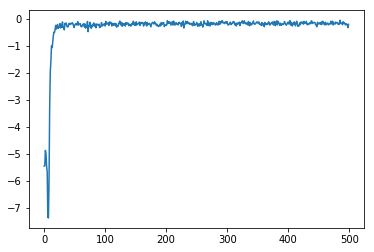

In [9]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)